In [1]:
import os, sys
sys.path.append(os.path.dirname(sys.path[0]))
import torch

from utils_deepECpr.algo_utils import *
from algorithms.deepECpr_algo import *
from utils_deepECpr.measurement_utils import *

/home/shastri.19/anaconda3/envs/DPS_patch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shastri.19/anaconda3/envs/DPS_patch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/shastri.19/anaconda3/envs/DPS_patch/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Options

# Diffusion model related
model_config_location = "configs/model_config.yaml"
diffusion_config_location = "configs/diffusion_config.yaml"

# test data related
data_config_location = "configs/testdata_config.yaml"
image_number = 19 

# measurement related
measurement_type = "OSF" # this particular file is for OSF demo only; Results corresponds to the OSF demo
alpha = 8 # shot-noise level 

# HIO related
pre_run_HIO_file_location = '/local/storage/deepECpr_gitHub_data_files/HIO_pre_run/FFHQ_OSF_HIO_pre_run.npz' # HIO was run on the same measurement data following the procedure mentioned in the paper and the results were saved in a file
HIO_dict = np.load(pre_run_HIO_file_location)
HIO_recon_channel_corrected_using_correlation_combined = HIO_dict['HIO_recon_channel_corrected_using_correlation_combined'] # this has been flipped and rotated to align with channels and not with ground truth

# deepECpr related
damp_bar1 = 0.3
damp_bar2 = 0.075
EM_iteration_stop = 3
total_iterations = 200
std_input = 120/np.sqrt(2) # this is the standard deviation of the initialization noise # ./np.sqrt(2) becasue the input is complex
linear_tune = 0.15 # denoiser factor


In [3]:
# Get measurement

y, sig, x0, z0, _ = get_FFHQ_measurement(image_number, measurement_type, alpha, data_config_location, verbose = True)


Chosen Options 
 
Image Number      :  19
Measurement Type  :  OSF
Alpha             :  8
 


/home/shastri.19/Work_and_Course_Files/deepECpr_public/deepECpr/guided_diffusion/unet.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load(mode

-------------------------------------------
FINAL PSNR deepECpr :  37.14770355143719
-------------------------------------------


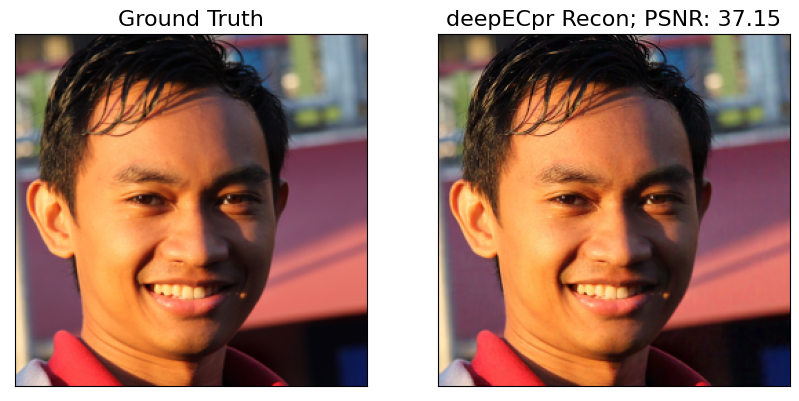

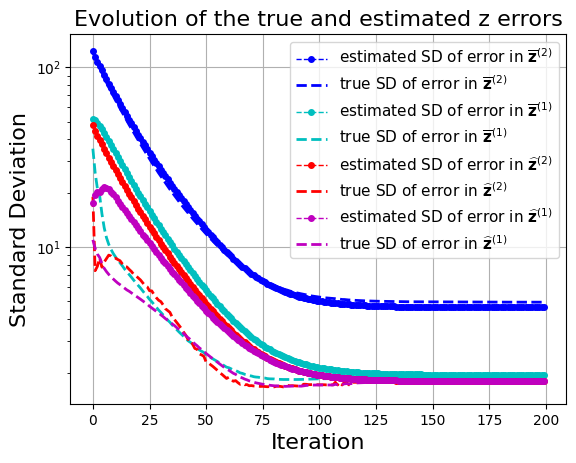

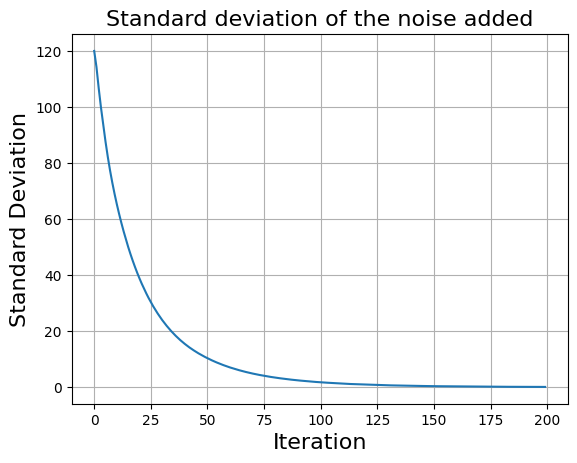

In [4]:
# OSF deepECpr image initialization using HIO

alpha_count = {4: 0, 6: 1}.get(alpha, 2)
alg_run = 0 # we choose the 0th run of the three runs
x_hat_HIO_init = torch.zeros_like(x0)
x_hat_HIO_init[0,0,:,:,:] = torch.from_numpy(HIO_recon_channel_corrected_using_correlation_combined[image_number,alg_run,alpha_count,:,:,:])

# Run deepECpr  

deepECpr_recon = run_deepECpr_OSF_for_demo(y, sig, x0, z0, model_config_location, diffusion_config_location, damp_bar1, damp_bar2, EM_iteration_stop, total_iterations, std_input, linear_tune, x_hat_HIO_init, verbose = False, my_device = 'cuda:0')